In [4]:
import CMZoom_utility as cmz
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from scipy.special import erf
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
import pyregion
print(np.__version__)
import aplpy
from matplotlib.ticker import FormatStrFormatter



1.18.5


In [5]:
#%matplotlib inline

In [22]:
##################################################################################################
### setup 
##################################################################################################
# picks for the accurate catalog
# rms = 3.0e6
# dend_min_v = 3
# dend_min_d = 1
# dend_min_pix = 17
# prune_min_peak = 6
# prune_min_mean = 2
# path = '/Users/hph/cmzoom_catalog/catalog_acc/'
# catalog = Table.read(path+'catalog_acc.fits')
#######################################
# ### picks for the complete catalog
rms = 3.0e6
dend_min_v = 3
dend_min_d = 1
dend_min_pix = 17
prune_min_peak = 4
prune_min_mean = 2
path = '/Users/hph/cmzoom_catalog/catalog_complete/'
catalog = Table.read(path+'catalog_complete.fits')
#################################################

### set condition to exclude sgrA*
#ca = (catalog['mask_num']==27)
#catalog.remove_rows(ca)
#######################################

date = '_02-02-20'
targetname = '_rms3e6_k14_dv'+str(dend_min_v)+'_dd'+str(dend_min_d)+'_dp'+str(dend_min_pix)+'_pp'+str(prune_min_peak)+'_pm'+str(prune_min_mean)+'_gal'+date

sma_path = path
herschel_path = path
catalog_path = path
figure_path = path

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


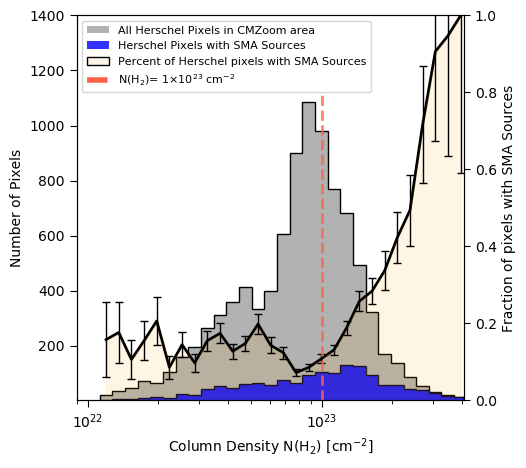

In [7]:
#########################################################
### Make figure of Herschel column density histogram
#########################################################
column_file = os.path.join(path, 'column_properunits_conv36_source_only.fits')
sma_file = os.path.join(path, 'CMZoom_continuum_pbcor.fits')
sma_mosaic = fits.open(sma_file)
sma_orig = sma_mosaic[0].data
sma_observed = np.isfinite(sma_orig)
column_fh = fits.open(column_file)

smaobserved_projto_herschel,_ = reproject.reproject_interp((sma_observed,
                                                            wcs.WCS(sma_mosaic[0].header).celestial),
                                                           column_fh[0].header)
smaobserved_projto_herschel[np.isnan(smaobserved_projto_herschel)] = 0
smaobserved_projto_herschel = smaobserved_projto_herschel.astype('bool')
colwcs = wcs.WCS(column_fh[0].header)
pix = colwcs.wcs_world2pix(catalog['glon'], catalog['glat'], 0)
column_dens = column_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]

### column density file handle
column_fh = fits.open(column_file)
column_masked = column_fh[0].data
column_masked[~smaobserved_projto_herschel] = np.nan

sb2_mask = pyregion.open(os.path.join('/Users/hph/Dropbox/CMZoom_Data/prototype_catalog/', 
                                      'sgrb2mask.reg')).get_mask(column_fh[0])

colmin = np.nanmin(column_masked[~sb2_mask])
colmax = np.nanmax(column_masked[~sb2_mask])


smasourcemask = np.zeros_like(smaobserved_projto_herschel, dtype='bool')

### for each source, "mask" a region that is within a herschel beam as "this region contains a source"
herschel_beamsize_pixels = (25*u.arcsec / np.mean(wcs.utils.proj_plane_pixel_scales(colwcs)*u.deg)).decompose()

### make a small radial mask
npix = int(np.ceil(herschel_beamsize_pixels))
yy,xx = np.indices([npix*2]*2, dtype='float')
rad = ((yy-npix+0.5)**2 + (xx-npix+0.5)**2)**0.5
radmask = rad < herschel_beamsize_pixels

pb = ProgressBar(len(catalog))
for row,(cx,cy) in zip(catalog, zip(*pix)):
    cy = int(np.round(cy))
    cx = int(np.round(cx))
    smasourcemask[cy-npix:cy+npix,cx-npix:cx+npix][radmask] = True
    pb.update()

plt.close()
plt.rcParams.update(plt.rcParamsDefault)

### Plot Histogram
plt.rcParams.update({'font.size': 10}) #set fontsize
histfig = plt.figure(3,figsize=(5,5))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Number of Pixels')
plt.xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

binnum = 30

linbins = np.linspace(colmin, colmax,binnum)
logbins = np.logspace(np.log10(colmin), np.log10(colmax),binnum)
h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
                   logbins, color='black',alpha=0.3, log=False,
                   label='Full cloud')
h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
                   logbins, color='black',alpha=1.0, log=False,histtype='step')
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.85, log=False, color='blue',
                   label='SMA Sources')
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.85, log=False, color='k', histtype='step')

ax3 = ax.twinx()
midpts = (l1[:-1] + l1[1:])/2.
p3 = line_frac = ax3.plot(midpts, h2/h1, linestyle='-', color='k', 
                     linewidth=2.0, zorder=-21,label='Fraction of pixels with SMA Sources')
perr = np.sqrt((h2/(h1**2))+((h2**2)/(h1**3)))
ax3.errorbar(midpts,h2/h1,yerr=perr,color='k',capsize=3.0,linewidth=1)
ax3.set_ylabel("Fraction of pixels with SMA Sources")
ax3.set_ylim(0,1)
fill = ax3.fill_between(midpts,h2/h1, color='orange',alpha=0.1)
ax3.set_label('Fraction of pixels with SMA Sources')

vx, vy = [1e23,1e23],[0,0.8]

p4 = ax3.plot(vx,vy,linestyle='--',linewidth=2.0,alpha=0.8,
              color='tomato', label='N(H$_2$)= 2$\times$10$^{23}$ cm$^{-2}$')
ax.set_xscale("log")


ax.set_xlim(9.0e21, colmax-1e22)

ax.set_ylim(1,1400)
ax.tick_params(axis='both',which='major',direction='out',length=5)
ax.tick_params(axis='both',which='major',direction='out',length=5)
ax.tick_params(axis='both',which='minor',direction='out',length=3)
ax.tick_params(axis='both',which='minor',direction='out',length=3)
ax3.tick_params(axis='both',which='major',direction='out',length=4)

plt.rcParams.update({'font.size': 8})
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='k',alpha=0.3, edgecolor='None',
                         label='All Herschel Pixels in CMZoom area'),
                   Patch(facecolor='b',alpha=0.8, edgecolor='None',
                         label='Herschel Pixels with SMA Sources'),
                   Patch(facecolor='#FEF5E7',alpha=0.99, edgecolor='k',
                         label='Percent of Herschel pixels with SMA Sources'),
                   Line2D([0], [0], color='tomato', lw=4, ls='--', label='N(H$_2$)= 1$\\times$10$^{23}$ cm$^{-2}$')]

ax.legend(handles=legend_elements, loc='upper left')

### Save figure
### Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'column_histograms_log'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')

plt.show()

print(perr)

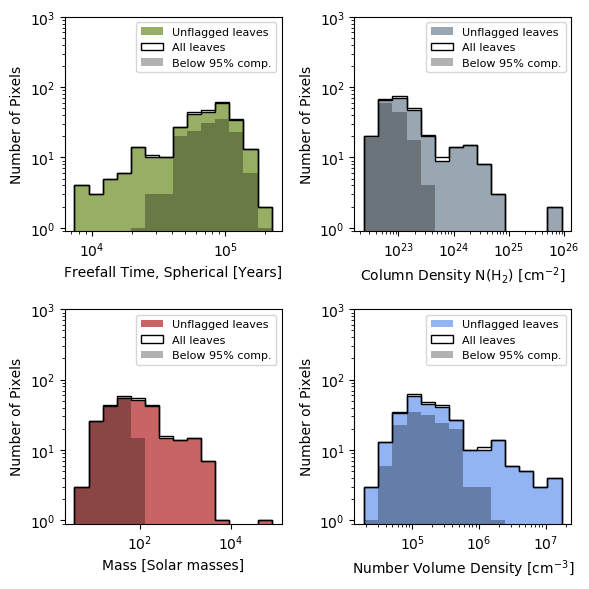

In [265]:
###########################################################################
### Physical property histograms with suspicion leaves separated
###########################################################################
#rlim = 0.12
incomp = (catalog['mass']<80)
scond= (catalog['suspicious']==1)
nscond= (catalog['suspicious']==0)
tff_arr = catalog['tff']
Column_N = catalog['sma_column']
mass_arr = catalog['mass']
Vol_n = catalog['n']

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
fig, axarr = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
###
axarr[0,0].set_ylabel('Number of Pixels')
axarr[0,0].set_xlabel('Freefall Time, Spherical [Years]')

tffmin, tffmax = min(tff_arr), max(tff_arr)
tff_logbins = np.logspace(np.log10(tffmin), np.log10(tffmax),15)
h1,l1,p1 = axarr[0,0].hist(tff_arr[nscond],
                   tff_logbins, color='olivedrab',alpha=0.7, log=True,
                   label='Unflagged leaves')
h1,l1,p1 = axarr[0,0].hist(tff_arr[nscond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[0,0].hist(tff,
#                    tff_logbins, color='k',alpha=0.5, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[0,0].hist(tff_arr,
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h1,l1,p1 = axarr[0,0].hist(tff_arr[incomp],
                   tff_logbins, color='k',alpha=0.3,log=True, label='Below 95% comp.')

axarr[0,0].set_xscale("log")
axarr[0,0].legend(loc='best', shadow=False, fontsize=8)
axarr[0,0].set_ylim(0.9,1000)
####
axarr[0,1].set_ylabel('Number of Pixels')
axarr[0,1].set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

Nmin, Nmax = min(Column_N[scond]), max(Column_N[nscond])
Nmin, Nmax = min(Column_N), max(Column_N)
N_logbins = np.logspace(np.log10(Nmin), np.log10(Nmax),15)

h1,l1,p1 = axarr[0,1].hist(Column_N[nscond],
                   N_logbins, color='slategrey',alpha=0.7, log=True,
                   label='Unflagged leaves')
h1,l1,p1 = axarr[0,1].hist(Column_N[nscond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[0,1].hist(Column_N,
#                    N_logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[0,1].hist(Column_N,
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h1,l1,p1 = axarr[0,1].hist(Column_N[incomp],
                   N_logbins, color='k',alpha=0.3, log=True, label='Below 95% comp.')

axarr[0,1].set_xscale("log")
axarr[0,1].legend(loc='best', shadow=False, fontsize=8)
axarr[0,1].set_ylim(0.9,1000)

####
axarr[1,0].set_ylabel('Number of Pixels')
axarr[1,0].set_xlabel('Mass [Solar masses]')


#massmin, massmax = min(mass_arr[nscond]), max(mass_arr[nscond])
massmin, massmax = min(mass_arr), max(mass_arr)
logbins = np.logspace(np.log10(massmin), np.log10(massmax),15)
h12,l1,p1 = axarr[1,0].hist(mass_arr[nscond],
                   logbins, color='firebrick',alpha=0.7, log=True,
                   label='Unflagged leaves')
h12,l1,p1 = axarr[1,0].hist(mass_arr[nscond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)
# h12,l1,p1 = axarr[1,0].hist(mass,
#                    logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h12,l1,p1 = axarr[1,0].hist(mass_arr,
                   logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h12,l1,p1 = axarr[1,0].hist(mass_arr[incomp],
                   logbins, color='k',alpha=0.3, log=True, label='Below 95% comp.')

axarr[1,0].set_xscale("log")
axarr[1,0].legend(loc='best', shadow=False, fontsize=8)
axarr[1,0].set_ylim(0.9,1000)


axarr[1,1].set_ylabel('Number of Pixels')
axarr[1,1].set_xlabel('Number Volume Density [cm$^{-3}$]')
nmin, nmax = min(Vol_n[nscond]), max(Vol_n[nscond])
n_logbins = np.logspace(np.log10(nmin), np.log10(nmax),15)
h1,l1,p1 = axarr[1,1].hist(Vol_n[nscond],
                   n_logbins, color='cornflowerblue',alpha=0.7, log=True,
                   label='Unflagged leaves')
h1,l1,p1 = axarr[1,1].hist(Vol_n[nscond],
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[1,1].hist(Vol_n,
#                    n_logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[1,1].hist(Vol_n,
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h1,l1,p1 = axarr[1,1].hist(Vol_n[incomp],
                   n_logbins, color='k',alpha=0.3, log=True, label='Below 95% comp.')

axarr[1,1].set_xscale("log")
axarr[1,1].legend(loc='best', shadow=False, fontsize=8)
axarr[1,1].set_ylim(0.9,1000)

####

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'histogram_4panel'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()


In [9]:
###############################
### find lower cutoff for MR
###############################
r_arr = np.linspace(0.001,50,10)
r_arr_pc = (r_arr/206265)*cmz.distance
lowrms=3e6 #jy/sr
lowcut=4*lowrms ### 3 sigma limit on leaf edge pixel flux
lowcut_bgsub = 1*lowrms
intflux = lowcut*np.pi*(r_arr/206265)**2
intflux_bgsub = lowcut_bgsub*((r_arr*1)/206265)**2
### find mass from integrated flux
masscut = cmz.mass_calc_submm(cmz.Wave, 20.0, 
                              cmz.Kappa, intflux, cmz.distance)
masscut_bgsub = cmz.mass_calc_submm(cmz.Wave, 20.0,
                              cmz.Kappa, intflux_bgsub, cmz.distance)
print(np.log10(masscut_bgsub))
print(np.log10(masscut))
print(np.log10(r_arr))


[-6.9574599   0.53213405  1.13411588  1.48627234  1.73613678  1.92994899
  2.08830627  2.22219613  2.33817723  2.44048011]
[-5.85825004  1.63134391  2.23332574  2.5854822   2.83534665  3.02915886
  3.18751614  3.32140599  3.4373871   3.53968997]
[-3.          0.74479698  1.04578789  1.22186612  1.34679834  1.44370445
  1.52288309  1.58982802  1.64781857  1.69897   ]


In [92]:
np.concatenate(([5,6,7,8],[1,2,3,4]))

array([5, 6, 7, 8, 1, 2, 3, 4])

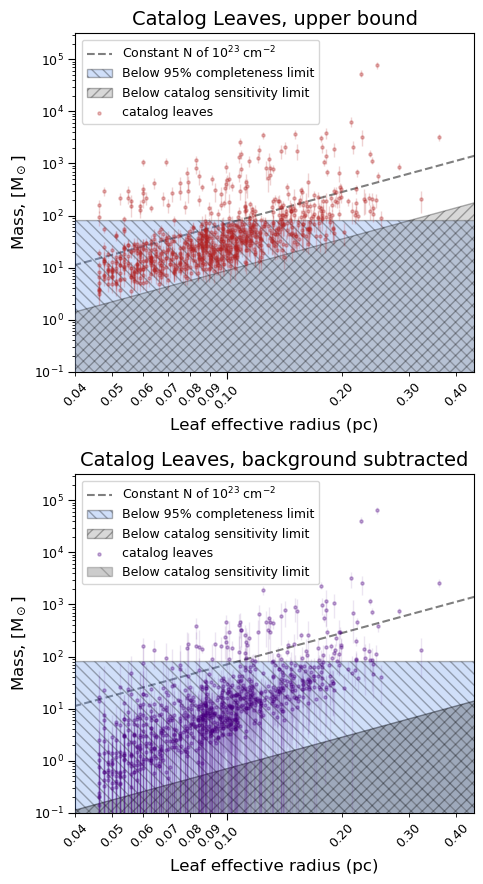

In [23]:
mass = catalog['mass']
r_eff_pc = catalog['r_eff_pc']
noise_mass = catalog['mass_unc']
noise_mass_bgsub = catalog['mass_bgsub_unc']
incomp = (catalog['mass']<80)
logyerr=(np.log10(mass)-np.log10(mass-noise_mass),
            np.log10(mass+noise_mass)-np.log10(mass))
mass_bin = np.array([min(mass),max(mass)])
radius_vals = cmz.radius_from_mass_const_col_density(mass_bin,1.0*10**23)
mass_bgsub = catalog['mass_bgsub']

plt.close()
plt.rcParams.update({'font.size': 12}) #set fontsize

f = plt.figure(figsize=(5,9))

ax1 = f.add_subplot(211)
ax1.set_title('Catalog Leaves, upper bound',fontsize=14)
ax1.scatter(r_eff_pc,mass,s=20, color='firebrick',
             alpha=.3,marker='.',zorder=2000,label='catalog leaves')
ax1.errorbar(x=r_eff_pc,y=mass,
             yerr=noise_mass,
             ls='none',color='firebrick',alpha=.2,marker='', linewidth=1.0,zorder=2000)
ax1.plot(radius_vals,mass_bin,color='k',ls='--',
         label='Constant N of 10$^{23}$ cm$^{-2}$',alpha=0.5)

ax1.fill(np.concatenate((r_arr_pc,r_arr_pc)), 
         np.concatenate((np.zeros_like(masscut)-1.,np.repeat(80,len(r_arr_pc)))),
         facecolor='cornflowerblue', alpha=0.3, edgecolor='k', hatch='\\\\\\', zorder=30,
         label='Below 95% completeness limit')
ax1.fill(np.concatenate((r_arr_pc,r_arr_pc)), np.concatenate((np.zeros_like(masscut)-1.,masscut)),
         facecolor='grey', alpha=0.3, edgecolor='k', hatch='///', zorder=30,
         label='Below catalog sensitivity limit')
ax1.set_xlabel('Leaf effective radius (pc)',fontsize=12)
ax1.set_ylabel('Mass, [M$_\odot$]',fontsize=12)
ax1.set_ylim(10**(-1),10**5.5)
ax1.set_xlim(5**(-2),15**(-0.3))
ax1.set_xscale('log')
ax1.tick_params(axis='x', which='major', rotation=45, labelsize=9,length=5)
ax1.tick_params(axis='y', which='major', rotation=0, labelsize=9,length=5)
ax1.tick_params(axis='x', which='minor',rotation=45, labelsize=9,length=3)
ax1.xaxis.set_minor_formatter(FormatStrFormatter("%1.2f"))
ax1.xaxis.set_major_formatter(FormatStrFormatter("%1.2f"))
ax1.set_yscale('log')
ax1.legend(loc='upper left', shadow=False, fontsize=9)

ax2 = f.add_subplot(212)
ax2.set_title('Catalog Leaves, background subtracted',fontsize=14)
ax2.scatter( r_eff_pc,mass_bgsub,s=20, color='indigo',
             alpha=.3,marker='.',zorder=2000,label='catalog leaves')
ax2.errorbar(x=r_eff_pc,y=mass_bgsub,
             yerr=noise_mass_bgsub,
             ls='none',color='indigo',alpha=.1,marker='', linewidth=1.0,zorder=2000)
ax2.plot(radius_vals,mass_bin,color='k',ls='--',
         label='Constant N of 10$^{23}$ cm$^{-2}$',alpha=0.5)
ax2.fill_between(r_arr_pc,np.zeros_like(masscut_bgsub)-1.,masscut_bgsub,color='k',
                 label='Below catalog sensitivity limit',alpha=0.2,hatch='\\')
ax2.fill(np.concatenate((r_arr_pc,r_arr_pc)), 
         np.concatenate((np.zeros_like(masscut_bgsub)-1.,np.repeat(80,len(r_arr_pc)))),
         facecolor='cornflowerblue', alpha=0.3, edgecolor='k', hatch='\\\\\\', zorder=30,
         label='Below 95% completeness limit')
ax2.fill(np.concatenate((r_arr_pc,r_arr_pc)), np.concatenate((np.zeros_like(masscut_bgsub)-1.,masscut_bgsub)),
         facecolor='grey', alpha=0.3, edgecolor='k', hatch='///', zorder=30,
         label='Below catalog sensitivity limit')

ax2.set_xlabel('Leaf effective radius (pc)',fontsize=12)
ax2.set_ylabel('Mass, [M$_\odot$]',fontsize=12)
ax2.set_ylim(10**(-1),10**5.5)
ax2.set_xlim(5**(-2),15**(-0.3))
ax2.set_xscale('log')
ax2.tick_params(axis='x', which='major', rotation=45, labelsize=9,length=5)
ax2.tick_params(axis='y', which='major', rotation=0, labelsize=9,length=5)
ax2.tick_params(axis='x', which='minor',rotation=45, labelsize=9,length=3)
ax2.xaxis.set_minor_formatter(FormatStrFormatter("%1.2f"))
ax2.xaxis.set_major_formatter(FormatStrFormatter("%1.2f"))
ax2.set_yscale('log')
ax2.legend(loc='upper left', shadow=False, fontsize=9)

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'twofig_subtracted_mass_radius'+targetname+'.pdf',
            format='pdf', dpi=100, bbox_inches='tight')
plt.show()

76975.75381877534


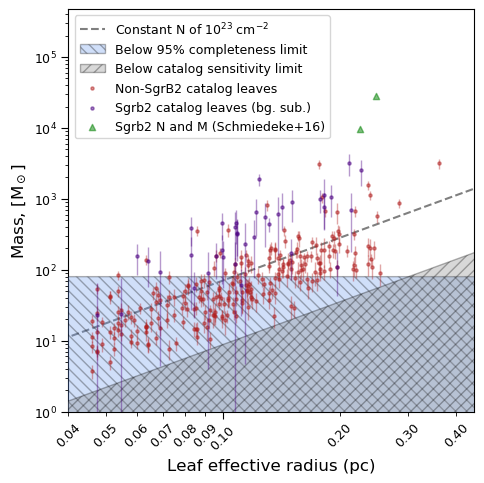

In [21]:
##########################################################
### same but plotting bg sub masses for sgrb2
##########################################################

sgrb2 = (catalog['mask_num']==9) & (catalog['leaf_ID']!='G0.699-0.028a') & (catalog['leaf_ID']!='G0.699-0.028b')
nsgrb2 = (catalog['mask_num']!=9)
sgrb2nm = (catalog['leaf_ID']=='G0.699-0.028a') | (catalog['leaf_ID']=='G0.699-0.028b')
catalog['mass_bgsub'][catalog['leaf_ID']=='G0.699-0.028a']=27897.0
catalog['mass_bgsub'][catalog['leaf_ID']=='G0.699-0.028b']=9572.0

print(mass.max())
r_eff_pc = catalog['r_eff_pc']
noise_mass = catalog['mass_unc']
noise_mass_bgsub = catalog['mass_bgsub_unc']
incomp = (catalog['mass']<80)
logyerr=(np.log10(mass)-np.log10(mass-noise_mass),
            np.log10(mass+noise_mass)-np.log10(mass))
mass_bin = np.array([min(mass),max(mass)])
radius_vals = cmz.radius_from_mass_const_col_density(mass_bin,1.0*10**23)
mass_bgsub = catalog['mass_bgsub']

plt.close()
plt.rcParams.update({'font.size': 12}) #set fontsize

f = plt.figure(figsize=(5,5))
ax1 = f.add_subplot(111)
ax1.scatter(r_eff_pc[nsgrb2],mass[nsgrb2],s=20, color='firebrick',
             alpha=.5,marker='.',zorder=2000,label='Non-SgrB2 catalog leaves')
ax1.errorbar(x=r_eff_pc[nsgrb2],y=mass[nsgrb2],
             yerr=noise_mass[nsgrb2],
             ls='none',color='firebrick',alpha=.4,marker='', linewidth=1.0,zorder=2000)
ax1.scatter(r_eff_pc[sgrb2],mass_bgsub[sgrb2],s=20, color='indigo',
             alpha=.5,marker='.',zorder=2000,label='Sgrb2 catalog leaves (bg. sub.)')
ax1.errorbar(x=r_eff_pc[sgrb2],y=mass_bgsub[sgrb2],
             yerr=noise_mass_bgsub[sgrb2],
             ls='none',color='indigo',alpha=.4,marker='', linewidth=1.0,zorder=2000)
ax1.scatter(r_eff_pc[sgrb2nm],mass_bgsub[sgrb2nm],s=20, color='green',
             alpha=.5,marker='^',zorder=2000,label='Sgrb2 N and M (Schmiedeke+16)')
ax1.plot(radius_vals,mass_bin,color='k',ls='--',
         label='Constant N of 10$^{23}$ cm$^{-2}$',alpha=0.5)
ax1.fill(np.concatenate((r_arr_pc,r_arr_pc)), np.concatenate((np.zeros_like(masscut)-1.,np.repeat(80,len(r_arr_pc)))),
         facecolor='cornflowerblue', alpha=0.3, edgecolor='k', hatch='\\\\\\', zorder=30,
         label='Below 95% completeness limit')
ax1.fill(np.concatenate((r_arr_pc,r_arr_pc)), np.concatenate((np.zeros_like(masscut)-1.,masscut)),
         facecolor='grey', alpha=0.3, edgecolor='k', hatch='///', zorder=30,
         label='Below catalog sensitivity limit')
ax1.set_xlabel('Leaf effective radius (pc)',fontsize=12)
ax1.set_ylabel('Mass, [M$_\odot$]',fontsize=12)
ax1.set_ylim(10**(0),1.5*10**5.5)
ax1.set_xlim(5**(-2),15**(-0.3))
ax1.set_xscale('log')
ax1.tick_params(axis='x', which='major', rotation=45, labelsize=9,length=5)
ax1.tick_params(axis='y', which='major', rotation=0, labelsize=9,length=5)
ax1.tick_params(axis='x', which='minor',rotation=45, labelsize=9,length=3)
ax1.xaxis.set_minor_formatter(FormatStrFormatter("%1.2f"))
ax1.xaxis.set_major_formatter(FormatStrFormatter("%1.2f"))
ax1.set_yscale('log')
ax1.legend(loc='upper left', shadow=False, fontsize=9)

plt.tight_layout()

### Save figure
### Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'sgrb2_mr'+targetname+'.pdf',
            format='pdf', dpi=100, bbox_inches='tight')
plt.show()
catalog = Table.read(path+'catalog_acc.fits')
#catalog = Table.read(path+'catalog_complete.fits')



76975.75381877534
[1.00000000e-02 8.55287042e+03 1.71057308e+04 2.56585913e+04
 3.42114517e+04 4.27643121e+04 5.13171725e+04 5.98700330e+04
 6.84228934e+04 7.69757538e+04]


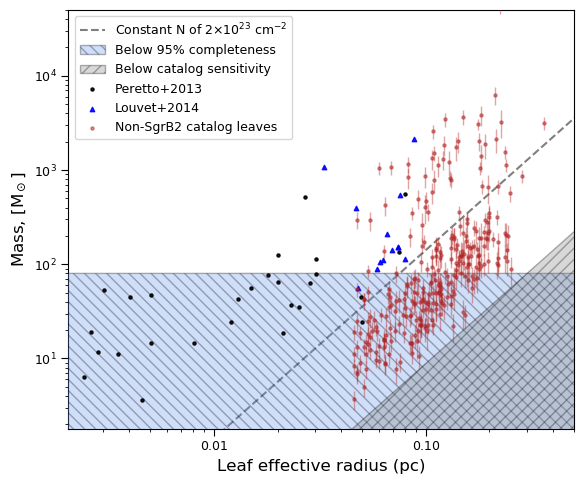

In [114]:
#######################################
### Comparison to Louvet/Peretto cores
#######################################

r_peretto =np.array([0.002432,0.002636,0.002829,0.003037,0.003551,0.004029,0.004571,0.005032,0.005032,0.008048,0.01211,
            0.01300,0.01505,0.01805,0.02007,0.02007,0.02111,0.02312,0.02519,0.02704,0.02844,0.03021,0.03037,
            0.04956,0.04981,0.07461,0.07967])
r_louvet = np.array([0.088,0.076,0.066,0.074,0.074,0.069,0.063,0.061,0.048,0.059,0.080,0.033,0.047])
m_peretto =np.array([6.340,19.02,11.73,52.91,11.28,44.56,3.581,14.55,47.57,14.52,24.65,42.69,55.64,76.73,124.3,64.67,
            18.68,36.60,34.89,519.4,63.36,78.03,115.0,44.52,24.27,135.9,563.1])
m_louvet =np.array([2128,545,211,153,153,141,111,105,56,88,115,1080,395])

print(mass.max())
r_eff_pc = catalog['r_eff_pc']
noise_mass = catalog['mass_unc']
noise_mass_bgsub = catalog['mass_bgsub_unc']
incomp = (catalog['mass']<80)
mass_bin = np.linspace(0.01,max(mass),10)
print(mass_bin)
radius_vals = cmz.radius_from_mass_const_col_density(mass_bin,2.0*10**23)
mass_bgsub = catalog['mass_bgsub']

plt.close()
plt.rcParams.update({'font.size': 12}) #set fontsize

f = plt.figure(figsize=(6,5))
ax1 = f.add_subplot(111)

ax1.scatter( r_peretto, m_peretto,s=20, color='k',
             alpha=.9,marker='.',zorder=2000,label='Peretto+2013')
ax1.scatter( r_louvet, m_louvet,s=10, color='blue',
             alpha=.9,marker='^',zorder=2000,label='Louvet+2014')
ax1.scatter(r_eff_pc,mass,s=20, color='firebrick',
             alpha=.5,marker='.',zorder=2000,label='Non-SgrB2 catalog leaves')
ax1.errorbar(x=r_eff_pc,y=mass,
             yerr=noise_mass,
             ls='none',color='firebrick',alpha=.4,marker='', linewidth=1.0,zorder=2000)

ax1.plot(radius_vals,mass_bin,color='k',ls='--',
         label='Constant N of 2$\\times$10$^{23}$ cm$^{-2}$',alpha=0.5)
ax1.fill(np.concatenate((r_arr_pc,r_arr_pc)), np.concatenate((np.zeros_like(masscut)-1.,np.repeat(80,len(r_arr_pc)))),
         facecolor='cornflowerblue', alpha=0.3, edgecolor='k', hatch='\\\\\\', zorder=30,
         label='Below 95% completeness')
ax1.fill(np.concatenate((r_arr_pc,r_arr_pc)), np.concatenate((np.zeros_like(masscut)-1.,masscut)),
         facecolor='grey', alpha=0.3, edgecolor='k', hatch='///', zorder=30,
         label='Below catalog sensitivity')
ax1.set_xlabel('Leaf effective radius (pc)',fontsize=12)
ax1.set_ylabel('Mass, [M$_\odot$]',fontsize=12)
ax1.set_ylim(1.8*10**0,0.5*10**5.)
ax1.set_xlim(1.3*10**-2.8,10**-0.3)
ax1.set_xscale('log')
ax1.tick_params(axis='x', which='major', rotation=0, labelsize=9,length=5)
ax1.tick_params(axis='y', which='major', rotation=0, labelsize=9,length=5)

ax1.xaxis.set_major_formatter(FormatStrFormatter("%1.2f"))
ax1.set_yscale('log')
ax1.legend(loc='upper left', shadow=False, fontsize=9)

plt.tight_layout()

### Save figure
### Need to save it as a PDF, otherewise, lose transparency
plt.savefig(path+'core_comparison'+targetname+'.pdf')
plt.show()

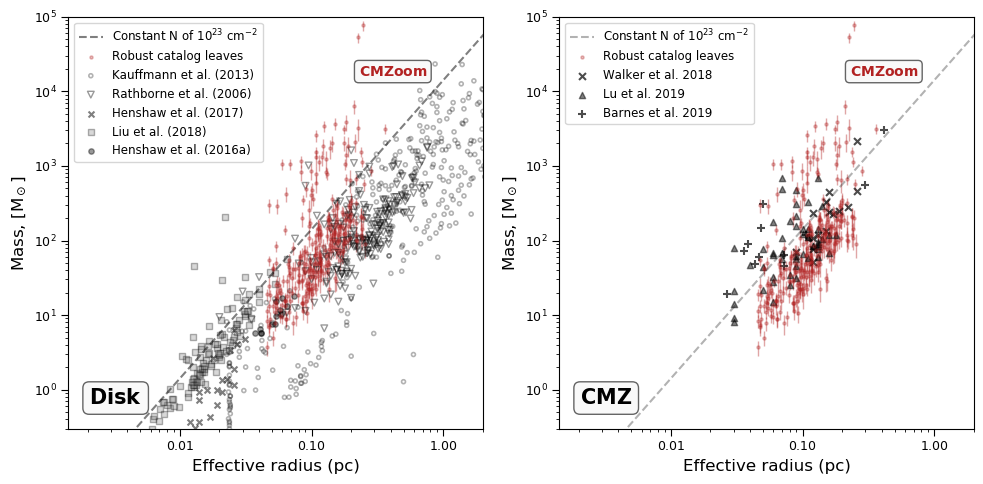

In [15]:
### Comparison to Louvet/Peretto cores

r_peretto =np.array([0.002432,0.002636,0.002829,0.003037,0.003551,0.004029,0.004571,0.005032,0.005032,0.008048,0.01211,
            0.01300,0.01505,0.01805,0.02007,0.02007,0.02111,0.02312,0.02519,0.02704,0.02844,0.03021,0.03037,
            0.04956,0.04981,0.07461,0.07967])
r_louvet = np.array([0.088,0.076,0.066,0.074,0.074,0.069,0.063,0.061,0.048,0.059,0.080,0.033,0.047])
m_peretto =np.array([6.340,19.02,11.73,52.91,11.28,44.56,3.581,14.55,47.57,14.52,24.65,42.69,55.64,76.73,124.3,64.67,
            18.68,36.60,34.89,519.4,63.36,78.03,115.0,44.52,24.27,135.9,563.1])
m_louvet =np.array([2128,545,211,153,153,141,111,105,56,88,115,1080,395])

r_eff_pc = catalog['r_eff_pc']
noise_mass = catalog['mass_unc']
noise_mass_bgsub = catalog['mass_bgsub_unc']
incomp = (catalog['mass']<80)
mass_bin = np.linspace(0.01,max(mass),10)
#mass_bin = np.array([min(catalog['mass']),max(catalog['mass'])])
radius_vals = cmz.radius_from_mass_const_col_density(mass_bin,2.0*10**23)
mass_bgsub = catalog['mass_bgsub']

plt.close()
plt.rcParams.update({'font.size': 12}) #set fontsize

f, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1=axes[0]
ax2=axes[1]

ax1.scatter(r_eff_pc,mass,s=20, color='firebrick',
             alpha=.3,marker='.',zorder=2000,label='Robust catalog leaves')
ax1.errorbar(x=r_eff_pc,y=mass,
             yerr=noise_mass,
             ls='none',color='firebrick',alpha=.4,marker='', linewidth=1.0,zorder=0)

ax1.plot(radius_vals,mass_bin,color='k',ls='--',
         label='Constant N of 10$^{23}$ cm$^{-2}$',alpha=0.5)
# ax1.fill(np.concatenate((r_arr_pc,r_arr_pc)), 
#          np.concatenate((np.zeros_like(masscut)-1.,np.repeat(80,len(r_arr_pc)))),
#          facecolor='none', alpha=0.3, edgecolor='k', hatch='\\\\\\', zorder=30,
#          label='Below 95% completeness')
# ax1.fill(np.concatenate((r_arr_pc,r_arr_pc)), np.concatenate((np.zeros_like(masscut)-1.,masscut)),
#          facecolor='none', alpha=0.3, edgecolor='k', hatch='///', zorder=30,
#          label='Below catalog sensitivity')
ax1.set_xlabel('Effective radius (pc)',fontsize=12)
ax1.set_ylabel('Mass, [M$_\odot$]',fontsize=12)
# ax1.set_ylim(1.8*10**0,0.5*10**5.)
# ax1.set_xlim(1.3*10**-2.8,10**-0.3)
ax1.set_ylim(.3*10**0,1*10**5.)
ax1.set_xlim(0.9*10**-2.8,4*10**-0.3)
ax1.set_xscale('log')
ax1.tick_params(axis='x', which='major', rotation=0, labelsize=9,length=5)
ax1.tick_params(axis='y', which='major', rotation=0, labelsize=9,length=5)

ax1.xaxis.set_major_formatter(FormatStrFormatter("%1.2f"))
ax1.set_yscale('log')
#plt.rcParams.update({'font.size': 6}) #set fontsize

###### inserting ash's code
c_r06 = Table.read('/Users/hph/cmzoom_catalog/comparison_data/rathborne_final_2006.fits')
c_h16 = Table.read('/Users/hph/cmzoom_catalog/comparison_data/henshaw_final_2016.fits')
c_h17 = Table.read('/Users/hph/cmzoom_catalog/comparison_data/henshaw_final_2017.fits')
c_l18 = Table.read('/Users/hph/cmzoom_catalog/comparison_data/liu_final_2018.fits')
#c_rm_p13 = Table.read('/Users/hph/cmzoom_catalog/comparison_data/peretto_2013.csv')
c_rm_k13 = Table.read('/Users/hph/cmzoom_catalog/comparison_data/kauffmann_rm_2013.csv')

### disc:
ax1.scatter(c_rm_k13['radius_pc'], c_rm_k13['mass'],
           ec='k', fc='none', marker='o', s=8,lw=1.2, label='Kauffmann et al. (2013)', alpha=0.3, zorder=1)
ax1.scatter(c_r06['radius_pc'], c_r06['mass_rc'],  facecolor='none',edgecolors='k', alpha=0.4,
           marker='v', s=23, label='Rathborne et al. (2006)', zorder=2)
ax1.scatter(c_h17['radius_eff_pc'], c_h17['mass_rc'],  facecolor='none',edgecolors='k',
           c='k', marker='x', s=18, label='Henshaw et al. (2017)', zorder=2,alpha=0.5)
ax1.scatter(c_l18['radius_eff_pc'], c_l18['mass_pbcorr_rc'], facecolor='grey',edgecolors='k',
            alpha=0.3, marker='s', s=15, label='Liu et al. (2018)', zorder=2)
ax1.scatter(c_h16['radius_eff_pc'], c_h16['mass_rc'], facecolor='k',edgecolors='k',
           marker='o', s=15, label='Henshaw et al. (2016a)', zorder=2,alpha=0.4)

### cmz: 

ax2.scatter(r_eff_pc,mass,s=20, color='firebrick',
             alpha=.3,marker='.',zorder=2000,label='Robust catalog leaves')
ax2.errorbar(x=r_eff_pc,y=mass,
             yerr=noise_mass,
             ls='none',color='firebrick',alpha=.4,marker='', linewidth=1.0,zorder=0)

ax2.plot(radius_vals,mass_bin,color='k',ls='--',
         label='Constant N of 10$^{23}$ cm$^{-2}$',alpha=0.3)
ax2.set_xlabel('Effective radius (pc)',fontsize=12)
ax2.set_ylabel('Mass, [M$_\odot$]',fontsize=12)
# ax2.set_ylim(1*10**0,1*10**5.)
# ax2.set_xlim(0.5*5**(-2),1*10**(-0.3))
ax2.set_ylim(.3*10**0,1*10**5.)
ax2.set_xlim(0.9*10**-2.8,4*10**-0.3)
ax2.set_xscale('log')
ax2.tick_params(axis='x', which='major', rotation=0, labelsize=9,length=5)
ax2.tick_params(axis='y', which='major', rotation=0, labelsize=9,length=5)
ax2.xaxis.set_major_formatter(FormatStrFormatter("%1.2f"))
ax2.set_yscale('log')

infile_cloud_d = '/Users/hph/cmzoom_catalog/comparison_data/cloud_d_master_table.txt'
master_table_cloud_d = Table.read(infile_cloud_d, format='ascii.fixed_width')
infile_cloud_ef = '/Users/hph/cmzoom_catalog/comparison_data/cloud_ef_master_table.txt'
master_table_cloud_ef = Table.read(infile_cloud_ef, format='ascii.fixed_width')
cores_walker = np.genfromtxt('/Users/hph/cmzoom_catalog/comparison_data/radius_mass_velocity_virial_cmz_walker_2018.txt', 
                             delimiter = ',')
cores_lu = np.genfromtxt('/Users/hph/cmzoom_catalog/comparison_data/radius_virial_mass_lu_2018.txt', 
                         delimiter = ' ')
colour = 'k'

ax2.scatter(cores_walker[:,[0]],cores_walker[:,[1]],color='k',zorder=100,
           s=25,marker='x',alpha=0.7,label='Walker et al. 2018')
ax2.scatter(cores_lu[:,0], cores_lu[:,1], s = 20, 
            edgecolors='k', facecolors='k', marker='^',
            zorder = 100, label = 'Lu et al. 2019', alpha = 0.5)

ax2.scatter(np.concatenate((master_table_cloud_ef['Effective Radius'],master_table_cloud_d['Effective Radius'])),
            np.concatenate((master_table_cloud_ef['Mass'],master_table_cloud_d['Mass'])),color='k',zorder=100,
           s=40,marker='+',alpha=0.7,label='Barnes et al. 2019')


### plot box for CMZ
bbox=dict(facecolor='whitesmoke', alpha=0.6, boxstyle='round')
ax2.text(0.05, 0.05, r'${\bf CMZ}$', fontsize=15, 
            transform=ax2.transAxes, ha='left', va='bottom',
            bbox=bbox, color='black')
#### plot box with red font to further highlight cmzoom?
ax2.text(0.7, 0.85, r'${\bf CMZoom}$', fontsize=10, 
            transform=ax2.transAxes, ha='left', va='bottom',
            bbox=bbox, color='firebrick')

bbox=dict(facecolor='whitesmoke', alpha=0.6, boxstyle='round')
ax1.text(0.05, 0.05, r'${\bf Disk}$', fontsize=15, 
            transform=ax1.transAxes, ha='left', va='bottom',
            bbox=bbox, color='black')
#### plot box with red font to further highlight cmzoom?
ax1.text(0.7, 0.85, r'${\bf CMZoom}$', fontsize=10, 
            transform=ax1.transAxes, ha='left', va='bottom',
            bbox=bbox, color='firebrick')

ax1.legend(loc='upper left', shadow=False, fontsize=8.5)
ax2.legend(loc='upper left', shadow=False, fontsize=8.5)


plt.tight_layout()

### Save figure
### Need to save it as a PDF, otherewise, lose transparency
plt.savefig(path+'core_comparison'+targetname+'.pdf')
plt.show()

76975.75381877534


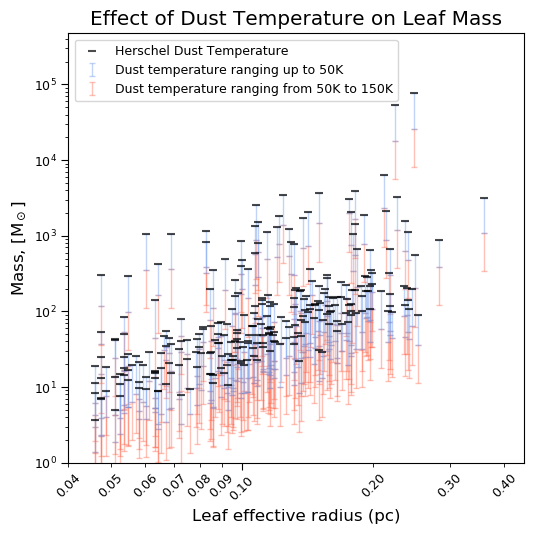

In [103]:
#######################################################
### effect of assumed dust temp. on MR relationship
#######################################################

print(mass.max())
r_eff_pc = catalog['r_eff_pc']
noise_mass = catalog['mass_unc']
noise_mass_bgsub = catalog['mass_bgsub_unc']
incomp = (catalog['mass']<80)
logyerr=(np.log10(mass)-np.log10(mass-noise_mass),
            np.log10(mass+noise_mass)-np.log10(mass))
mass_bin = np.array([min(mass),max(mass)])
radius_vals = cmz.radius_from_mass_const_col_density(mass_bin,2.0*10**23)
mass_bgsub = catalog['mass_bgsub']

plt.close()
plt.rcParams.update({'font.size': 12}) #set fontsize

f = plt.figure(figsize=(5.5,5.5))
ax1 = f.add_subplot(111)

ax1.set_xlabel('Leaf effective radius (pc)',fontsize=12)
ax1.set_ylabel('Mass, [M$_\odot$]',fontsize=12)
flux_integrated=catalog['flux_integrated']

low_dustTemp = catalog['DustTemperature']
mid_dustTemp = 50
high_dustTemp = 150

mass_vals_mid = cmz.mass_calc_submm(cmz.Wave, mid_dustTemp, cmz.Kappa, flux_integrated, cmz.distance)
mass_vals_high = cmz.mass_calc_submm(cmz.Wave,high_dustTemp, cmz.Kappa, flux_integrated, cmz.distance)
mass_diff_mid = mass_vals_mid - mass
mass_diff_high = mass_vals_high - mass_vals_mid

ax1.set_title('Effect of Dust Temperature on Leaf Mass')
ax1.scatter(r_eff_pc, mass, color='black',alpha=.7, 
           label='Herschel Dust Temperature',marker='_',s=30.,zorder =22)
zeros = np.zeros(shape = mass.shape)
ax1.errorbar(x=r_eff_pc, y=mass_vals_mid,
            yerr=[mass_diff_mid,zeros], ls='none',color='cornflowerblue',alpha = 0.4,
            label='Dust temperature ranging up to 50K',capsize=2,linewidth=1.0)

ax1.errorbar(x=r_eff_pc, y=mass_vals_mid, 
            yerr=[zeros,mass_diff_high], ls='none',color='tomato',alpha = 0.4,uplims=False,
            label='Dust temperature ranging from 50K to 150K',capsize=2, zorder=1,linewidth=1.0)

ax1.set_xlabel('Leaf effective radius (pc)',fontsize=12)
ax1.set_ylabel('Mass, [M$_\odot$]',fontsize=12)
ax1.set_ylim(10**(0),1.5*10**5.5)
ax1.set_xlim(5**(-2),15**(-0.3))
ax1.set_xscale('log')
ax1.tick_params(axis='x', which='major', rotation=45, labelsize=9,length=5)
ax1.tick_params(axis='y', which='major', rotation=0, labelsize=9,length=5)
ax1.tick_params(axis='x', which='minor',rotation=45, labelsize=9,length=3)
ax1.xaxis.set_minor_formatter(FormatStrFormatter("%1.2f"))
ax1.xaxis.set_major_formatter(FormatStrFormatter("%1.2f"))
ax1.set_yscale('log')
#plt.rcParams.update({'font.size': 6}) #set fontsize
ax1.legend(loc='upper left', shadow=False, fontsize=9)

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'MR_temp_bar'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()




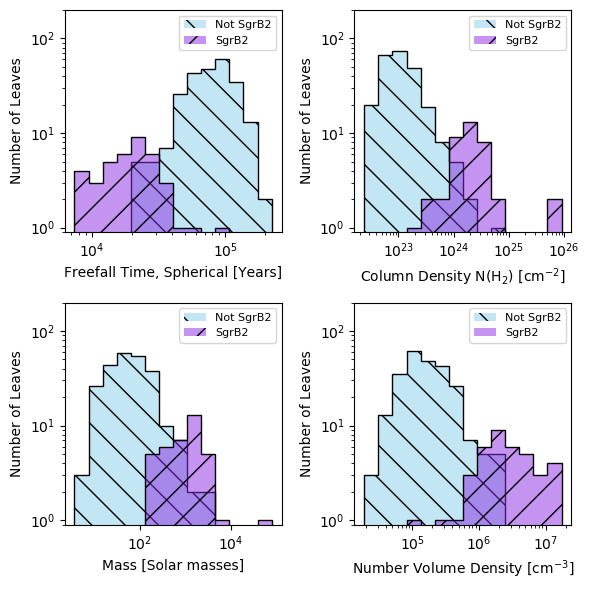

In [110]:
#########################################################
### Histograms but with SgrB2 separation
#########################################################
rlim = 0.12
sgrb2cond = (catalog['mask_num']==9)
nsgrb2cond = (catalog['mask_num']!=9)
tff=catalog['tff']
Column_N=catalog['sma_column']
Vol_n=catalog['n']

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, axarr = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
###
axarr[0,0].set_ylabel('Number of Leaves')
axarr[0,0].set_xlabel('Freefall Time, Spherical [Years]')

tffmin, tffmax = min(tff), max(tff)
tff_logbins = np.logspace(np.log10(tffmin), np.log10(tffmax),15)
h1,l1,p1 = axarr[0,0].hist(tff[nsgrb2cond],
                   tff_logbins, color='skyblue',alpha=0.5,hatch='\\', log=True,
                   label='Not SgrB2')
h1,l1,p1 = axarr[0,0].hist(tff[nsgrb2cond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)
h1,l1,p1 = axarr[0,0].hist(tff[sgrb2cond],
                   tff_logbins, color='blueviolet',alpha=0.5,hatch='/', log=True,
                   label='SgrB2')
h1,l1,p1 = axarr[0,0].hist(tff[sgrb2cond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)
axarr[0,0].set_xscale("log")
axarr[0,0].legend(loc='best', shadow=False, fontsize=8)
axarr[0,0].set_ylim(0.9,200)

####
axarr[0,1].set_ylabel('Number of Leaves')
axarr[0,1].set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

Nmin, Nmax = min(Column_N), max(Column_N)
N_logbins = np.logspace(np.log10(Nmin), np.log10(Nmax),15)
h1,l1,p1 = axarr[0,1].hist(Column_N[nsgrb2cond],
                   N_logbins, color='skyblue',alpha=0.5, hatch='\\', log=True,
                   label='Not SgrB2')
h1,l1,p1 = axarr[0,1].hist(Column_N[nsgrb2cond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)
h1,l1,p1 = axarr[0,1].hist(Column_N[sgrb2cond],
                   N_logbins, color='blueviolet',alpha=0.5, hatch='/', log=True,
                   label='SgrB2')
h1,l1,p1 = axarr[0,1].hist(Column_N[sgrb2cond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[0,1].set_xscale("log")
axarr[0,1].legend(loc='best', shadow=False, fontsize=8)
axarr[0,1].set_ylim(0.9,200)

####
axarr[1,0].set_ylabel('Number of Leaves')
axarr[1,0].set_xlabel('Mass [Solar masses]')


massmin, massmax = min(mass), max(mass)
logbins = np.logspace(np.log10(massmin), np.log10(massmax),15)
h12,l1,p1 = axarr[1,0].hist(mass[nsgrb2cond],
                   logbins, color='skyblue',alpha=0.5,hatch='\\', log=True,
                   label='Not SgrB2')
h12,l1,p1 = axarr[1,0].hist(mass[nsgrb2cond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)
h12,l1,p1 = axarr[1,0].hist(mass[sgrb2cond],
                   logbins, color='blueviolet',alpha=0.5,hatch='/', log=True,
                   label='SgrB2')
h12,l1,p1 = axarr[1,0].hist(mass[sgrb2cond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[1,0].set_xscale("log")
axarr[1,0].legend(loc='best', shadow=False, fontsize=8)
axarr[1,0].set_ylim(0.9,200)

####

axarr[1,1].set_ylabel('Number of Leaves')
axarr[1,1].set_xlabel('Number Volume Density [cm$^{-3}$]')
nmin, nmax = min(Vol_n), max(Vol_n)
n_logbins = np.logspace(np.log10(nmin), np.log10(nmax),15)
h1,l1,p1 = axarr[1,1].hist(Vol_n[nsgrb2cond],
                   n_logbins, color='skyblue',alpha=0.5, hatch='\\', log=True,
                   label='Not SgrB2')
h1,l1,p1 = axarr[1,1].hist(Vol_n[nsgrb2cond],
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)
n_logbins = np.logspace(np.log10(nmin), np.log10(nmax),15)
h1,l1,p1 = axarr[1,1].hist(Vol_n[sgrb2cond],
                   n_logbins, color='blueviolet',alpha=0.5, hatch='/',log=True,
                   label='SgrB2')
h1,l1,p1 = axarr[1,1].hist(Vol_n[sgrb2cond],
                   n_logbins, color='k',alpha=1.0,histtype='step',log=True)

axarr[1,1].set_xscale("log")
axarr[1,1].legend(loc='best', shadow=False, fontsize=8)
axarr[1,1].set_ylim(0.9,200)

####

plt.tight_layout()

#### Save figure
#### Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'sgrb2_4panel'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()


